In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score,confusion_matrix
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score
from PIL import Image
import cv2

import os
import shutil

In [2]:
covid_path = '/content/drive/MyDrive/Final_Project/CovidDataset/CovidDataset/Train/Covid'
normal_path = '/content/drive/MyDrive/Final_Project/CovidDataset/CovidDataset/Train/Normal'

In [3]:
data_path = '/content/drive/MyDrive/Final_Project/CovidDataset/CovidDataset'

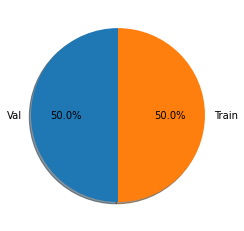

In [4]:
class_names = os.listdir(data_path)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(data_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

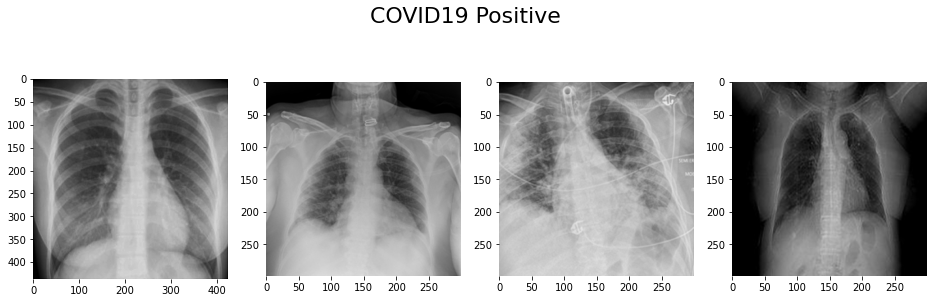

In [5]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(covid_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(covid_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

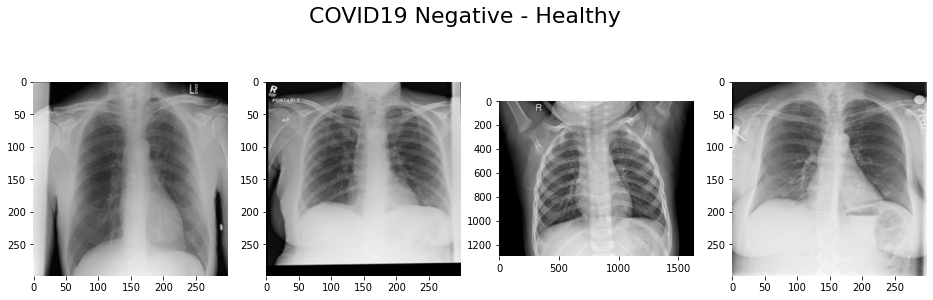

In [6]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(normal_path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(normal_path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [7]:
train_path='/content/drive/MyDrive/Final_Project/CovidDataset/CovidDataset/Train'
val_path='/content/drive/MyDrive/Final_Project/CovidDataset/CovidDataset/Val'

In [8]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"Train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "Val": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.CenterCrop(224), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [9]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['Train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['Val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(data_path, .2)
dataloaders = {"Train":trainloader, "Val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['Train','Val']}
class_names = trainloader.dataset.classes
print(class_names)

['Train', 'Val']


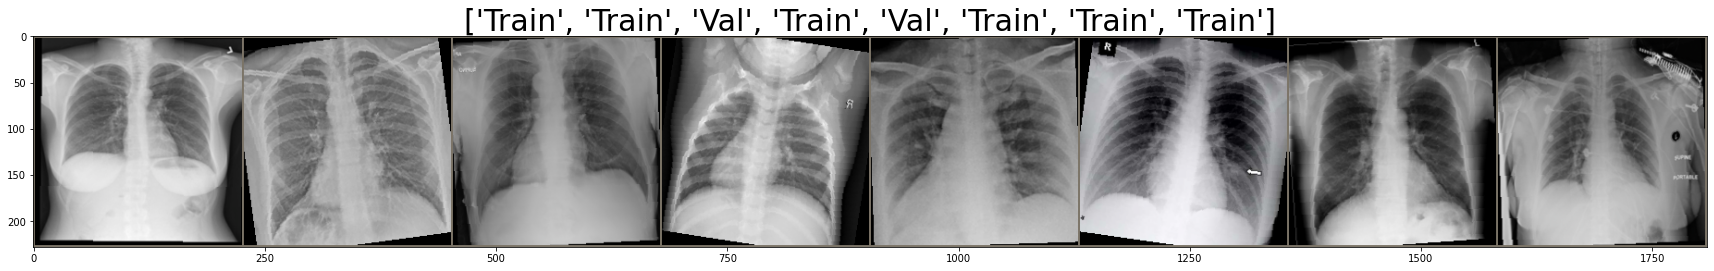

In [10]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [12]:
torch.cuda.empty_cache()

In [13]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [14]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6955906


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                if phase == 'Train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'Val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'Val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Train Loss: 0.6238 | Train Accuracy: 0.8069


Val Loss: 0.5831 | Val Accuracy: 0.8455 | Kappa Score: nan
Val loss Decreased from inf to 0.5831 
Saving Weights... 

Epoch 2/10
----------


Train Loss: 0.5782 | Train Accuracy: 0.8171


Val Loss: 0.5678 | Val Accuracy: 0.8455 | Kappa Score: nan
Val loss Decreased from 0.5831 to 0.5678 
Saving Weights... 

Epoch 3/10
----------


Train Loss: 0.5875 | Train Accuracy: 0.8150


Val Loss: 0.5698 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 4/10
----------


Train Loss: 0.5884 | Train Accuracy: 0.8150


Val Loss: 0.5803 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 5/10
----------


Train Loss: 0.5904 | Train Accuracy: 0.8150


Val Loss: 0.5636 | Val Accuracy: 0.8455 | Kappa Score: nan
Val loss Decreased from 0.5678 to 0.5636 
Saving Weights... 

Epoch 6/10
----------


Train Loss: 0.5769 | Train Accuracy: 0.8191


Val Loss: 0.5941 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 7/10
----------


Train Loss: 0.5729 | Train Accuracy: 0.8171


Val Loss: 0.5887 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 8/10
----------


Train Loss: 0.5767 | Train Accuracy: 0.8211


Val Loss: 0.5898 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 9/10
----------


Train Loss: 0.5991 | Train Accuracy: 0.8171


Val Loss: 0.5866 | Val Accuracy: 0.8455 | Kappa Score: nan

Epoch 10/10
----------


Train Loss: 0.5655 | Train Accuracy: 0.8171


Val Loss: 0.5974 | Val Accuracy: 0.8455 | Kappa Score: nan

Training complete in 6m 3s
Best val loss: 0.5636


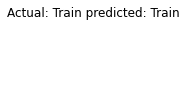

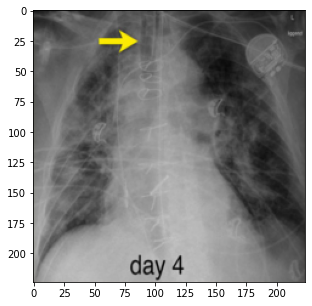

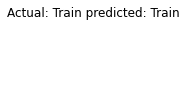

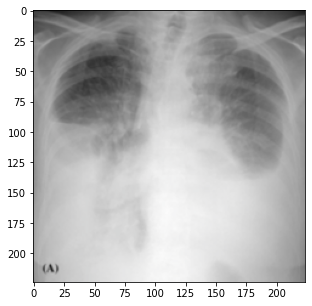

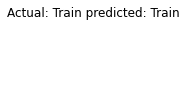

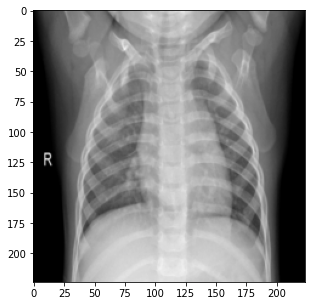

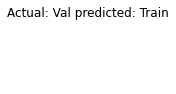

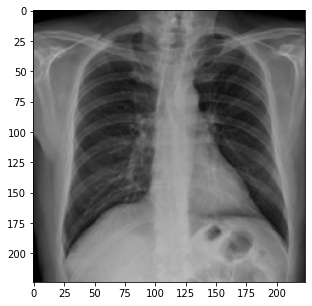

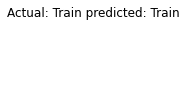

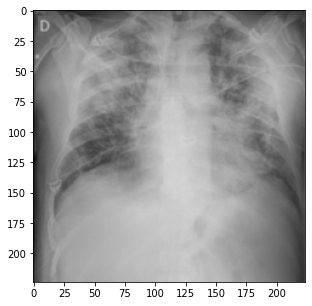

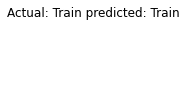

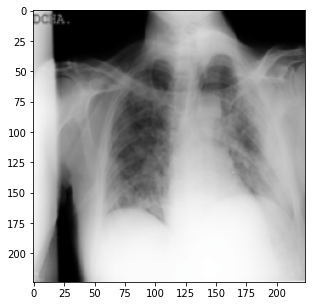

In [18]:
visualize_model(base_model)
plt.show()

In [20]:
test_data_path = '/content/drive/MyDrive/Copy_Final_Project/Dataset/Test'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(test_data_path, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)


In [21]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [22]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

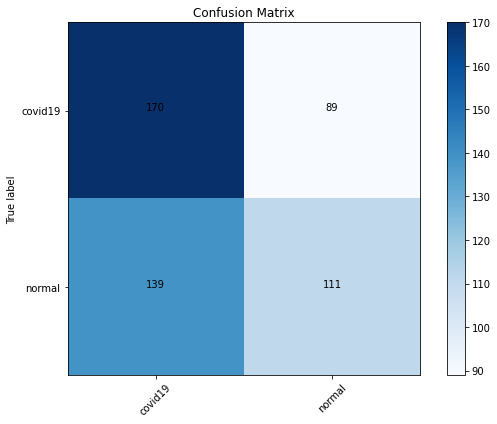

In [29]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [30]:
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

In [34]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
print("Precision =",precision_score(y_true_list,y_pred_list))
print("Recall =",recall_score(y_true_list,y_pred_list))
print("F1 Score =",f1_score(y_true_list,y_pred_list))


# calculate the specificity
conf_specificity = (TN / float(TN + FP))
print("Specificity = ",conf_specificity)

Precision = 0.555
Recall = 0.444
F1 Score = 0.49333333333333335
Specificity =  0.6563706563706564


In [35]:
torch.save(base_model.state_dict(), 'best_model.pth')